# C3 — Créateur de Posts Réseaux Sociaux

Notebook de démonstration du générateur de contenus optimisés pour **LinkedIn**, **Instagram** et **Twitter/X**.

**Fonctionnalités démontrées :**
1. Génération multi-plateforme avec adaptation automatique du ton
2. Structured Outputs (Pydantic + JSON Schema strict)
3. Génération de visuels avec DALL-E 3
4. Suggestion de hashtags et créneaux de publication
5. Variations A/B pour tests d'engagement
6. Export des résultats (JSON, Markdown)

**Prérequis :** Clé API OpenAI (GPT-4o + DALL-E 3)

**Durée estimée :** 30-45 minutes

**Références :**
- [`GenAI/Texte/3_Structured_Outputs.ipynb`](https://github.com/jsboige/CoursIA/blob/main/MyIA.AI.Notebooks/GenAI/Texte/3_Structured_Outputs.ipynb)
- [`GenAI/Images/01-1-OpenAI-DALL-E-3.ipynb`](https://github.com/jsboige/CoursIA/blob/main/MyIA.AI.Notebooks/GenAI/Images/01-1-OpenAI-DALL-E-3.ipynb)

## 0. Installation et Configuration

Installez les dépendances et configurez votre clé API OpenAI.

In [1]:
# Installation des dépendances
%pip install -q openai python-dotenv pydantic requests Pillow


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import os

# Ajouter le dossier parent au path pour importer src/
sys.path.insert(0, os.path.abspath('..'))

from dotenv import load_dotenv
load_dotenv(os.path.join('..', '.env'))

# Vérifier que la clé API est configurée
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    print("⚠️  OPENAI_API_KEY non trouvée !")
    print("Créez un fichier .env dans le dossier groupe-social-media-creator/ avec :")
    print("OPENAI_API_KEY=sk-...")
else:
    print(f"✅ Clé API configurée (se termine par ...{api_key[-4:]})")

✅ Clé API configurée (se termine par ...llcA)


In [3]:
import importlib
import src.utils
import src.models
import src.platforms
import src.generator
import src.image_generator
import src.ab_analysis

# Recharger tous les modules pour prendre en compte les modifications
importlib.reload(src.utils)
importlib.reload(src.models)
importlib.reload(src.platforms)
importlib.reload(src.image_generator)
importlib.reload(src.generator)
importlib.reload(src.ab_analysis)

# Import des modules du projet
from src.generator import SocialMediaGenerator
from src.image_generator import ImageGenerator
from src.models import PostRequest, Platform, Tone, ContentType
from src.platforms import get_platform_config, get_platform_summary, PLATFORMS
from src.utils import (
    format_full_output,
    format_post_display,
    format_ab_output,
    export_to_json,
    export_posts_markdown,
)
from src.ab_analysis import (
    print_test_a,
    print_test_b,
    print_all_tests,
    print_comparaison,
    print_verdict,
    print_ab_full_analysis,
    compare_variations,
)

# Initialiser le générateur
generator = SocialMediaGenerator()
print("✅ Générateur de posts initialisé")
print(f"   Modèle : {generator.model}")
print()
print(get_platform_summary())

✅ Générateur de posts initialisé
   Modèle : gpt-4o-mini

Plateformes supportées :

  • LinkedIn : max 3000 car., image 1200×627px, 5 hashtags recommandés
  • Instagram : max 2200 car., image 1080×1080px, 15 hashtags recommandés
  • Twitter/X : max 280 car., image 1600×900px, 2 hashtags recommandés


## 1. Comprendre les Plateformes

Avant de générer du contenu, explorons les **spécificités de chaque plateforme**.
Le système adapte automatiquement le ton, la longueur et le format.

| Plateforme | Ton | Longueur Max | Image | Hashtags |
|------------|-----|-------------|-------|----------|
| **LinkedIn** | Professionnel, inspirant | 3000 car. | 1200×627 px | 5 recommandés |
| **Instagram** | Créatif, engageant | 2200 car. | 1080×1080 px | 15 recommandés |
| **Twitter/X** | Concis, percutant | 280 car. | 1600×900 px | 2 recommandés |

In [4]:
# Explorer les configurations de chaque plateforme
for name, config in PLATFORMS.items():
    print(f"\n{'═' * 50}")
    print(f"  📱 {config.display_name}")
    print(f"{'═' * 50}")
    print(f"  Max caractères : {config.max_characters}")
    print(f"  Image : {config.image_dimensions[0]}×{config.image_dimensions[1]}px")
    print(f"  DALL-E size : {config.dalle_size}")
    print(f"  Hashtags : {config.recommended_hashtags} recommandés (max {config.max_hashtags})")
    print(f"  Emojis : {config.emoji_usage}")
    print(f"\n  💡 Astuces :")
    for tip in config.content_tips:
        print(f"    • {tip}")
    print(f"\n  ⏰ Meilleurs créneaux :")
    for slot in config.best_posting_times:
        print(f"    • {slot['jour']} à {slot['heure']} — {slot['raison']}")


══════════════════════════════════════════════════
  📱 LinkedIn
══════════════════════════════════════════════════
  Max caractères : 3000
  Image : 1200×627px
  DALL-E size : 1792x1024
  Hashtags : 5 recommandés (max 10)
  Emojis : Modéré (2-5 emojis max, professionnels : 🚀 💡 ✅ 📊 🎯)

  💡 Astuces :
    • Les posts avec une histoire personnelle obtiennent 3x plus d'engagement
    • Les carrousels (PDF) génèrent 10x plus de portée que les posts texte
    • Poser une question augmente les commentaires de 50%
    • Les chiffres dans l'accroche captent l'attention

  ⏰ Meilleurs créneaux :
    • Mardi à 08:00 — Pic d'activité professionnelle matinale
    • Mercredi à 10:00 — Forte consultation en milieu de semaine
    • Jeudi à 12:00 — Pause déjeuner, consultation mobile

══════════════════════════════════════════════════
  📱 Instagram
══════════════════════════════════════════════════
  Max caractères : 2200
  Image : 1080×1080px
  DALL-E size : 1024x1024
  Hashtags : 15 recommandés (max 

## 2. Génération Multi-Plateforme

### 2.1 Mode Simplifié : Un seul post

Commençons par générer un post pour **une seule plateforme** avec l'API simplifiée.
Le système utilise les **Structured Outputs** (JSON Schema strict) pour garantir
que la sortie contient tous les champs requis : texte, hashtags, timing, prompt d'image.

In [5]:
# Génération d'un post LinkedIn simple
result = generator.generate_post_simple(
    topic="Lancement d'un nouvel outil IA pour automatiser la création de contenu",
    platform="linkedin",
    tone="professionnel",
)

# Afficher le résultat formaté
print(format_full_output(result, show_image_prompts=True))

╔══════════════════════════════════════════════════════════════╗
║         🚀 POSTS RÉSEAUX SOCIAUX GÉNÉRÉS                   ║
╚══════════════════════════════════════════════════════════════╝

📌 Sujet : Lancement d'un nouvel outil IA pour automatiser la création de contenu
🎯 Objectif : notoriété

════════════════════════════════════════════════════════════
  📱 LINKEDIN
════════════════════════════════════════════════════════════

📝 Texte du post (1147 caractères) :
────────────────────────────────────────────────────────────
🚀 Je suis ravi de vous annoncer le lancement d'un nouvel outil révolutionnaire !

Dans un monde où le contenu est roi, nous devons constamment innover pour rester pertinents. Je sais par expérience à quel point il est difficile de produire du contenu de qualité en un temps record.

C'est pourquoi nous avons développé un outil d'intelligence artificielle qui automatise la création de contenu, permettant aux professionnels de gagner un temps précieux tout en maintena

### Analyse du Résultat

Le résultat inclut :
- **Texte adapté** : Structuré avec sauts de ligne, ton professionnel, CTA
- **Hashtags scorés** : Chaque hashtag est évalué (pertinence haute/moyenne/basse)
- **Créneaux optimaux** : 3 recommandations avec score d'engagement
- **Prompt DALL-E 3** : Prêt à être utilisé pour générer le visuel

Tout cela est **garanti par le JSON Schema strict** — pas de parsing fragile !

In [6]:
# Accéder aux données structurées de façon type-safe
post = result.posts[0]
print(f"Plateforme : {post.plateforme}")
print(f"Longueur : {post.longueur_caracteres} caractères")
print(f"Nombre de hashtags : {len(post.hashtags)}")
print(f"\nHashtags haute pertinence :")
for h in post.hashtags:
    if h.relevance == "haute":
        print(f"  #{h.tag}")
print(f"\nMeilleur créneau : {post.timing[0].jour} à {post.timing[0].heure}")
print(f"Prompt image : {post.image_prompt.prompt_en[:100]}...")

Plateforme : linkedin
Longueur : 1147 caractères
Nombre de hashtags : 5

Hashtags haute pertinence :
  #Innovation
  #IntelligenceArtificielle
  #MarketingDigital

Meilleur créneau : Mardi à 10:00
Prompt image : A professional setting showcasing a team excitedly collaborating on digital content creation using a...


### 2.2 Mode Complet : Toutes les Plateformes

Générons maintenant un post adapté à **LinkedIn, Instagram ET Twitter/X** en un seul appel.
Le modèle crée un contenu **unique pour chaque plateforme**, pas un simple copier-coller.

In [7]:
# Génération multi-plateforme complète
multi_result = generator.generate_all_platforms(
    topic="Notre entreprise vient de dépasser les 10 000 utilisateurs grâce à l'IA",
    tone="inspirant",
    content_type="annonce",
    target_audience="entrepreneurs et professionnels tech",
    key_message="L'IA transforme la productivité des équipes",
    brand_name="TechStartup",
)

# Afficher tous les posts
print(format_full_output(multi_result, show_image_prompts=True))

╔══════════════════════════════════════════════════════════════╗
║         🚀 POSTS RÉSEAUX SOCIAUX GÉNÉRÉS                   ║
╚══════════════════════════════════════════════════════════════╝

📌 Sujet : Notre entreprise vient de dépasser les 10 000 utilisateurs grâce à l'IA
🎯 Objectif : notoriété

════════════════════════════════════════════════════════════
  📱 LINKEDIN
════════════════════════════════════════════════════════════

📝 Texte du post (1230 caractères) :
────────────────────────────────────────────────────────────
🚀 Quel moment incroyable pour TechStartup !  
Nous venons de dépasser les 10 000 utilisateurs grâce à notre technologie d'intelligence artificielle.  

Cela ne se limite pas juste à un chiffre. Chaque nouvel utilisateur représente une équipe qui peut gagner en productivité, innover et repenser mes pratiques de travail grâce à l'IA.  

J'ai vu de mes propres yeux comment nos solutions ont transformé la manière dont les équipes collaborent.  
Les retours de nos util

### Comparaison Multi-Plateforme

Comparons les posts générés pour chaque plateforme :

In [8]:
# Tableau comparatif
print("╔══════════════════════════════════════════════════════════════════════════╗")
print("║              COMPARAISON MULTI-PLATEFORME                              ║")
print("╠══════════════════════════════════════════════════════════════════════════╣")
print(f"║ {'Critère':<20} │ {'LinkedIn':<16} │ {'Instagram':<16} │ {'Twitter/X':<12} ║")
print("╠══════════════════════════════════════════════════════════════════════════╣")

for post in multi_result.posts:
    pass  # Collecte des données

data = {p.plateforme: p for p in multi_result.posts}

def get_val(platform, attr):
    return getattr(data.get(platform, None), attr, 'N/A') if platform in data else 'N/A'

rows = [
    ("Caractères", 
     str(get_val('linkedin', 'longueur_caracteres')),
     str(get_val('instagram', 'longueur_caracteres')),
     str(get_val('twitter', 'longueur_caracteres'))),
    ("Nb hashtags",
     str(len(data.get('linkedin', type('', (), {'hashtags': []})()).hashtags)) if 'linkedin' in data else 'N/A',
     str(len(data.get('instagram', type('', (), {'hashtags': []})()).hashtags)) if 'instagram' in data else 'N/A',
     str(len(data.get('twitter', type('', (), {'hashtags': []})()).hashtags)) if 'twitter' in data else 'N/A'),
    ("Nb emojis",
     str(len(data['linkedin'].emojis_utilises)) if 'linkedin' in data else 'N/A',
     str(len(data['instagram'].emojis_utilises)) if 'instagram' in data else 'N/A',
     str(len(data['twitter'].emojis_utilises)) if 'twitter' in data else 'N/A'),
    ("Style image",
     data['linkedin'].image_prompt.style[:14] if 'linkedin' in data else 'N/A',
     data['instagram'].image_prompt.style[:14] if 'instagram' in data else 'N/A',
     data['twitter'].image_prompt.style[:10] if 'twitter' in data else 'N/A'),
]

for label, li, ig, tw in rows:
    print(f"║ {label:<20} │ {li:<16} │ {ig:<16} │ {tw:<12} ║")

print("╚══════════════════════════════════════════════════════════════════════════╝")

╔══════════════════════════════════════════════════════════════════════════╗
║              COMPARAISON MULTI-PLATEFORME                              ║
╠══════════════════════════════════════════════════════════════════════════╣
║ Critère              │ LinkedIn         │ Instagram        │ Twitter/X    ║
╠══════════════════════════════════════════════════════════════════════════╣
║ Caractères           │ 1230             │ 995              │ 274          ║
║ Nb hashtags          │ 5                │ 14               │ 3            ║
║ Nb emojis            │ 1                │ 2                │ 2            ║
║ Style image          │ photographic     │ illustration     │ photograph   ║
╚══════════════════════════════════════════════════════════════════════════╝


## 3. Génération de Visuels (DALL-E 3)

Chaque post inclut un **prompt d'image optimisé pour DALL-E 3**.
Utilisons-le pour générer le visuel associé.

Les dimensions sont automatiquement adaptées :
- **LinkedIn** : 1792×1024 (paysage)
- **Instagram** : 1024×1024 (carré)
- **Twitter/X** : 1792×1024 (paysage)

**Référence** : [`GenAI/Images/01-1-OpenAI-DALL-E-3.ipynb`](https://github.com/jsboige/CoursIA/blob/main/MyIA.AI.Notebooks/GenAI/Images/01-1-OpenAI-DALL-E-3.ipynb)

In [9]:
# Initialiser le générateur d'images
img_gen = ImageGenerator()
print(img_gen.get_platform_image_info())

Dimensions d'images par plateforme :

  • LinkedIn : 1200×627px (DALL-E: 1792x1024)
  • Instagram : 1080×1080px (DALL-E: 1024x1024)
  • Twitter/X : 1600×900px (DALL-E: 1792x1024)


Prompt DALL-E 3 : A vibrant and dynamic office scene showing diverse professionals using AI technology on their devices, celebrating the achievement of 10,000 users. Elements of teamwork, innovation, and digital growth in a modern workspace.
Plateforme : linkedin

⏳ Génération en cours...

✅ Image générée !
   Taille DALL-E : 1792x1024
   Dimensions cible : 1200×627
   Prompt révisé : Generate an image showcasing a vibrant and dynamic office scene set in a modern workspace. The composition should include a variety of professionals o...


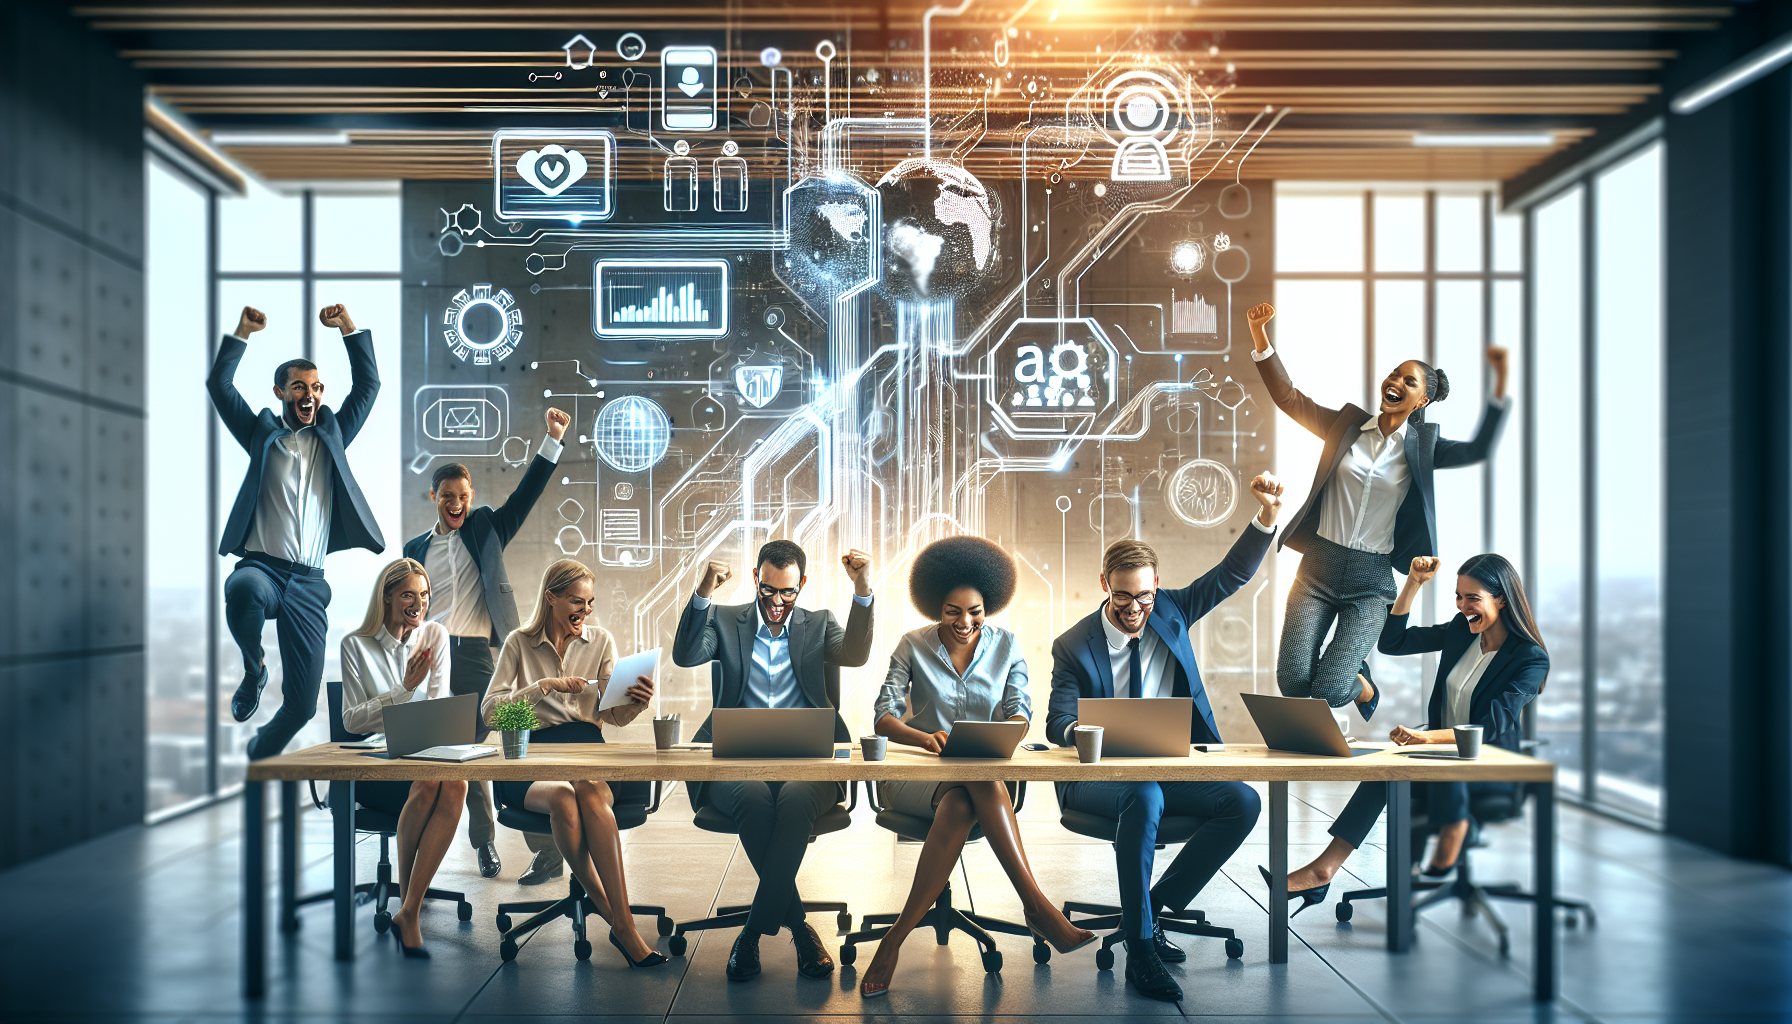

In [10]:
# Générer un visuel pour le premier post (LinkedIn)
linkedin_post = multi_result.posts[0]
image_prompt = linkedin_post.image_prompt.prompt_en

print(f"Prompt DALL-E 3 : {image_prompt}")
print(f"Plateforme : {linkedin_post.plateforme}")
print(f"\n⏳ Génération en cours...")

image_result = img_gen.generate_image(
    prompt=image_prompt,
    platform=linkedin_post.plateforme,
    quality="standard",
    style="vivid",
    save_path="../examples/sample_output/linkedin_visual.png",
)

print(f"\n✅ Image générée !")
print(f"   Taille DALL-E : {image_result['size']}")
print(f"   Dimensions cible : {image_result['target_dimensions']}")
print(f"   Prompt révisé : {image_result['revised_prompt'][:150]}...")

# Afficher l'image dans le notebook
ImageGenerator.display_image_from_url(image_result['url'])

Prompt Instagram : A colorful and vibrant graphic with the number 10,000 surrounded by elements representing technology, innovation, and teamwork. Include diverse people celebrating in an office with digital devices showcasing AI.

⏳ Génération en cours...

✅ Image Instagram générée ! (1024x1024)


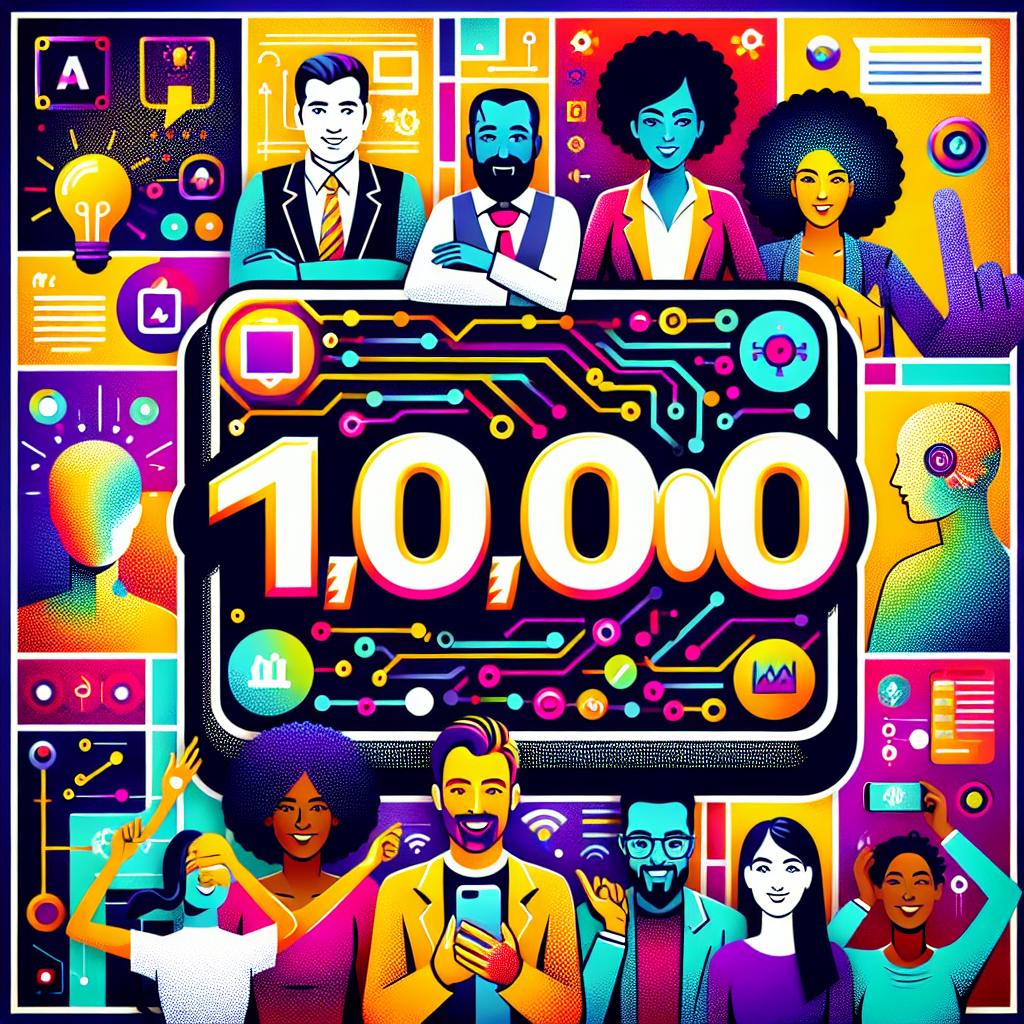

In [11]:
# Générer un visuel Instagram (carré)
instagram_posts = [p for p in multi_result.posts if p.plateforme == 'instagram']
if instagram_posts:
    ig_post = instagram_posts[0]
    print(f"Prompt Instagram : {ig_post.image_prompt.prompt_en}")
    print(f"\n⏳ Génération en cours...")
    
    ig_image = img_gen.generate_image(
        prompt=ig_post.image_prompt.prompt_en,
        platform="instagram",
        quality="standard",
        style="vivid",
        save_path="../examples/sample_output/instagram_visual.png",
    )
    
    print(f"\n✅ Image Instagram générée ! ({ig_image['size']})")
    ImageGenerator.display_image_from_url(ig_image['url'])
else:
    print("Pas de post Instagram dans les résultats")

## 4. Test A/B — Comparer les propositions de l'IA

Le test A/B génère **plusieurs versions d'un même post** avec des stratégies différentes.
L'objectif est de voir clairement **TEST A** et **TEST B** pour comparer les deux résultats
proposés par l'IA et choisir le meilleur.

Le module `src/ab_analysis.py` fournit des fonctions dédiées :

| Fonction | Rôle |
|----------|------|
| `print_test_a()` | Affiche le TEST A comme un post complet prêt-à-publier |
| `print_test_b()` | Affiche le TEST B comme un post complet prêt-à-publier |
| `print_comparaison()` | Compare A vs B : tableau de métriques + différences clés |
| `print_verdict()` | Classement final et recommandation de l'IA |
| `print_ab_full_analysis()` | Enchaîne tout : tests + comparaison + verdict |

In [12]:
# Générer 2 variations A/B pour LinkedIn
ab_result = generator.generate_ab_variations(
    topic="Nous recrutons 5 développeurs IA pour notre équipe R&D",
    platform="linkedin",
    num_variations=2,
    tone="professionnel",
    content_type="annonce",
    target_audience="développeurs Python et data scientists",
)

# ── Afficher les deux tests A et B + comparaison + verdict ──
print_ab_full_analysis(ab_result)

  ⏳ Génération de la variation A (Approche émotionnelle / storytelling)...
  ✅ Variation A générée
  ⏳ Génération de la variation B (Approche factuelle / données chiffrées)...
  ✅ Variation B générée
  ⏳ Génération de la recommandation...
  ✅ Recommandation générée

═════════════════════════════════════════════════════════════════
  🔬 TEST A/B — LINKEDIN
  📌 Sujet : Nous recrutons 5 développeurs IA pour notre équipe R&D
  📊 2 propositions générées par l'IA
═════════════════════════════════════════════════════════════════

╔═══════════════════════════════════════════════════════════════╗
║                            TEST A                             ║
║                           LINKEDIN                            ║
╚═══════════════════════════════════════════════════════════════╝

  Stratégie : Approche émotionnelle / storytelling
  Score estimé : élevé

┌───────────────────────────────────────────────────────────────┐
│                 POST TEL QU IL SERAIT PUBLIÉ                  │


### Test A/B sur Instagram

Même approche sur Instagram avec un sujet et un ton différents.
On utilise `print_ab_full_analysis()` pour obtenir l'analyse complète en un seul appel.

In [13]:
# Variations A/B pour Instagram
ab_instagram = generator.generate_ab_variations(
    topic="Nouveau produit bio révolutionnaire pour le soin de la peau",
    platform="instagram",
    num_variations=2,
    tone="créatif",
    content_type="promotion",
    target_audience="femmes 25-45 ans intéressées par le bien-être",
)

# Analyse complète : TEST A, TEST B, comparaison, verdict
print_ab_full_analysis(ab_instagram)

  ⏳ Génération de la variation A (Approche émotionnelle / storytelling)...
  ✅ Variation A générée
  ⏳ Génération de la variation B (Approche factuelle / données chiffrées)...
  ✅ Variation B générée
  ⏳ Génération de la recommandation...
  ✅ Recommandation générée

═════════════════════════════════════════════════════════════════
  🔬 TEST A/B — INSTAGRAM
  📌 Sujet : Nouveau produit bio révolutionnaire pour le soin de la peau
  📊 2 propositions générées par l'IA
═════════════════════════════════════════════════════════════════

╔═══════════════════════════════════════════════════════════════╗
║                            TEST A                             ║
║                           INSTAGRAM                           ║
╚═══════════════════════════════════════════════════════════════╝

  Stratégie : Approche émotionnelle / storytelling
  Score estimé : élevé

┌───────────────────────────────────────────────────────────────┐
│                 POST TEL QU IL SERAIT PUBLIÉ              

In [14]:
# Accès programmatique aux données de comparaison
# compare_variations() retourne un dict exploitable directement en Python
analysis = compare_variations(ab_instagram)

print("📊 Données extraites de l'analyse :\n")
for m in analysis["metrics"]:
    print(f"Version {m['version']}:")
    print(f"  Score numérique : {m['score_numerique']}/100")
    print(f"  Mots : {m['nb_mots']} | Hashtags : {m['nb_hashtags']} (qualité: {m['hashtag_score']}pts)")
    print(f"  Questions : {m['nb_questions']} | Exclamations : {m['nb_exclamations']}")
    print()

print(f"Hashtags communs : {analysis['hashtags_communs'] or '(aucun)'}")
for v, tags in analysis["hashtags_uniques"].items():
    print(f"Hashtags uniques [{v}] : {tags or '(tous partagés)'}")

📊 Données extraites de l'analyse :

Version A:
  Score numérique : 90/100
  Mots : 171 | Hashtags : 15 (qualité: 36pts)
  Questions : 0 | Exclamations : 2

Version B:
  Score numérique : 90/100
  Mots : 141 | Hashtags : 15 (qualité: 36pts)
  Questions : 2 | Exclamations : 4

Hashtags communs : {'#RoutineBeauté', '#PeauSaine'}
Hashtags uniques [A] : {'#BienEtre', '#SoinFemme', '#CrèmeHydratante', '#SkincareRoutine', '#GlowUp', '#Naturel', '#NouveauProduit', '#Bio', '#ProduitsNaturels', '#BeautéÉthique', '#SoinBio', '#EcoFriendly', '#AmourDeLaNature'}
Hashtags uniques [B] : {'#SkincareAddict', '#BeautéSaine', '#BienÊtre', '#SoinDeLaPeau', '#CleanBeauty', '#CosmétiqueNaturelle', '#LifestyleSain', '#BeauteBio', '#IngrédientsNaturels', '#Hydratation', '#PeauParfaite', '#BioBeauté', '#Wellness'}


## 5. API Avancée : Requête Personnalisée

Pour un contrôle plus fin, utilisez l'objet `PostRequest` qui permet de
spécifier tous les paramètres : audience, message clé, marque, type de contenu...

In [15]:
# Requête personnalisée avancée
request = PostRequest(
    topic="Conférence annuelle sur l'Intelligence Artificielle Responsable",
    platforms=[Platform.LINKEDIN, Platform.TWITTER],
    tone=Tone.INSPIRANT,
    content_type=ContentType.EVENEMENT,
    target_audience="décideurs, chercheurs IA et étudiants en informatique",
    key_message="L'IA éthique est l'avenir de la tech",
    brand_name="AI Ethics Summit",
    language="français",
)

result_custom = generator.generate_posts(request)
print(format_full_output(result_custom, show_image_prompts=True))

╔══════════════════════════════════════════════════════════════╗
║         🚀 POSTS RÉSEAUX SOCIAUX GÉNÉRÉS                   ║
╚══════════════════════════════════════════════════════════════╝

📌 Sujet : Conférence annuelle sur l'Intelligence Artificielle Responsable
🎯 Objectif : notoriété

════════════════════════════════════════════════════════════
  📱 LINKEDIN
════════════════════════════════════════════════════════════

📝 Texte du post (1021 caractères) :
────────────────────────────────────────────────────────────
🔍 L'avenir de la technologie se dessine devant nous.

Cette année, lors de l'AI Ethics Summit, nous allons explorer un sujet qui nous concerne tous : l'Intelligence Artificielle Responsable.

En tant que décideurs, chercheurs et étudiants, nous avons le pouvoir d'orienter l'IA vers un avenir éthique et durable.

👉 Pourquoi l'IA éthique est-elle la clef de notre futur ?  
Parce qu'elle nous permet de bâtir des systèmes qui respectent les valeurs humaines, tout en répondant

## 6. Export des Résultats

Les résultats peuvent être exportés en **JSON** (pour intégration API/BDD)
ou en **Markdown** (prêt à copier-coller).

In [16]:
# Export JSON (pour intégration API ou base de données)
json_path = export_to_json(
    multi_result,
    "../examples/sample_output/posts_multi_platform.json"
)
print(f"✅ Export JSON : {json_path}")

# Export Markdown (prêt à copier-coller)
md_path = export_posts_markdown(
    multi_result,
    "../examples/sample_output/posts_multi_platform.md"
)
print(f"✅ Export Markdown : {md_path}")

# Aperçu du JSON exporté
import json
with open(json_path, 'r', encoding='utf-8') as f:
    data = json.load(f)
print(f"\n📄 Aperçu JSON ({len(json.dumps(data))} octets) :")
print(json.dumps(data, indent=2, ensure_ascii=False)[:500] + "...")

✅ Export JSON : /Users/evanmse/Documents/Github/2025-MSBNS3IN03-GenAI/groupe-social-media-creator/examples/sample_output/posts_multi_platform.json
✅ Export Markdown : /Users/evanmse/Documents/Github/2025-MSBNS3IN03-GenAI/groupe-social-media-creator/examples/sample_output/posts_multi_platform.md

📄 Aperçu JSON (7252 octets) :
{
  "sujet": "Notre entreprise vient de dépasser les 10 000 utilisateurs grâce à l'IA",
  "objectif": "notoriété",
  "posts": [
    {
      "plateforme": "linkedin",
      "texte": "🚀 Quel moment incroyable pour TechStartup !  \nNous venons de dépasser les 10 000 utilisateurs grâce à notre technologie d'intelligence artificielle.  \n\nCela ne se limite pas juste à un chiffre. Chaque nouvel utilisateur représente une équipe qui peut gagner en productivité, innover et repenser mes pratiques de tra...


## 7. Structured Outputs en Détail

Cette section montre en détail comment les **Structured Outputs** fonctionnent
sous le capot, en s'appuyant sur le notebook de référence
[`GenAI/Texte/3_Structured_Outputs.ipynb`](https://github.com/jsboige/CoursIA/blob/main/MyIA.AI.Notebooks/GenAI/Texte/3_Structured_Outputs.ipynb).

### Pourquoi les Structured Outputs ?

| Aspect | JSON Mode classique | Structured Outputs |
|--------|--------------------|--------------------|  
| JSON valide | ✅ | ✅ |
| Structure garantie | ❌ | ✅ |
| Type-safe (Pydantic) | ❌ | ✅ |
| Champs garantis | ❌ | ✅ |
| Enum/contraintes | ❌ | ✅ |

In [17]:
# Visualiser le JSON Schema généré par Pydantic
from src.models import PostContent, SocialMediaOutput
from src.utils import add_additional_properties_false
import json

# Schéma brut Pydantic
schema_raw = PostContent.model_json_schema()
print("=== JSON Schema Pydantic (brut) ===")
print(json.dumps(schema_raw, indent=2, ensure_ascii=False)[:800])

# Schéma adapté pour OpenAI (additionalProperties: false)
schema_openai = add_additional_properties_false(
    PostContent.model_json_schema()
)
print("\n=== JSON Schema OpenAI (strict) ===")
print(json.dumps(schema_openai, indent=2, ensure_ascii=False)[:800])
print("\n...")
print(f"\nTotal : {len(json.dumps(schema_openai))} octets de schéma")

=== JSON Schema Pydantic (brut) ===
{
  "$defs": {
    "Hashtag": {
      "description": "Un hashtag avec son score de pertinence.",
      "properties": {
        "tag": {
          "description": "Le hashtag sans le #",
          "title": "Tag",
          "type": "string"
        },
        "relevance": {
          "description": "Pertinence: haute, moyenne, basse",
          "title": "Relevance",
          "type": "string"
        }
      },
      "required": [
        "tag",
        "relevance"
      ],
      "title": "Hashtag",
      "type": "object"
    },
    "ImagePrompt": {
      "description": "Prompt optimisé pour la génération d'image DALL-E 3.",
      "properties": {
        "prompt_en": {
          "description": "Prompt en anglais optimisé pour DALL-E 3",
          "title": "Prompt En",
          "type": "strin

=== JSON Schema OpenAI (strict) ===
{
  "description": "Contenu d'un post pour une plateforme donnée.",
  "properties": {
    "plateforme": {
      "description":

### Exemple Direct : Appel Structuré Brut

Pour comprendre le mécanisme, faisons un appel direct à l'API avec un schéma
simple dédié aux hashtags :

In [18]:
from openai import OpenAI
from pydantic import BaseModel, Field
from typing import List

# Modèle Pydantic simple pour démonstration
class HashtagSuggestion(BaseModel):
    hashtag: str = Field(description="Le hashtag sans le #")
    categorie: str = Field(description="Catégorie: tendance, niche, marque")
    popularite: str = Field(description="Popularité estimée: haute, moyenne, basse")

class HashtagSet(BaseModel):
    sujet: str = Field(description="Sujet analysé")
    plateforme: str = Field(description="Plateforme cible")
    hashtags: List[HashtagSuggestion] = Field(description="Hashtags suggérés")
    conseil: str = Field(description="Conseil d'utilisation")

# Appel avec Structured Outputs
client = OpenAI()
schema = add_additional_properties_false(HashtagSet.model_json_schema())

response = client.chat.completions.create(
    model=os.getenv('OPENAI_MODEL', 'gpt-4o-mini'),
    messages=[
        {"role": "system", "content": "Tu es un expert en social media marketing."},
        {"role": "user", "content": "Suggère 8 hashtags pour un post Instagram sur le développement durable et la tech."}
    ],
    response_format={
        "type": "json_schema",
        "json_schema": {
            "name": "hashtag_set",
            "strict": True,
            "schema": schema,
        }
    }
)

# Validation type-safe avec Pydantic
hashtag_result = HashtagSet.model_validate_json(response.choices[0].message.content)

print(f"Sujet : {hashtag_result.sujet}")
print(f"Plateforme : {hashtag_result.plateforme}")
print(f"\nHashtags suggérés :")
for h in hashtag_result.hashtags:
    print(f"  #{h.hashtag:<25} [{h.categorie}] popularité: {h.popularite}")
print(f"\n💡 Conseil : {hashtag_result.conseil}")

Sujet : Développement durable et technologie
Plateforme : Instagram

Hashtags suggérés :
  #sustainability            [tendance] popularité: haute
  #greeninnovation           [niche] popularité: moyenne
  #techforgood               [tendance] popularité: moyenne
  #cleantech                 [niche] popularité: moyenne
  #ecotech                   [niche] popularité: basse
  #futureoftech              [tendance] popularité: haute
  #sustainabletech           [niche] popularité: moyenne
  #digitaleco                [niche] popularité: basse

💡 Conseil : Utilisez un mélange de hashtags populaires et de niche pour élargir votre audience tout en ciblant des intérêts spécifiques.


## 8. Cas d'Usage Complet : Campagne Marketing

Simulons une **campagne marketing complète** :
1. Génération multi-plateforme
2. Variations A/B
3. Visuels DALL-E 3
4. Export des livrables

In [19]:
# ──── ÉTAPE 1 : Génération multi-plateforme ────
print("🚀 ÉTAPE 1 : Génération des posts multi-plateforme...\n")

campaign = generator.generate_all_platforms(
    topic="Lancement de notre application mobile de méditation guidée par IA",
    tone="inspirant",
    content_type="annonce",
    target_audience="millennials et Gen Z intéressés par le bien-être et la mindfulness",
    key_message="La sérénité à portée de main grâce à l'Intelligence Artificielle",
    brand_name="ZenMind AI",
)

print(format_full_output(campaign))
print("\n✅ Posts générés pour", len(campaign.posts), "plateformes")

🚀 ÉTAPE 1 : Génération des posts multi-plateforme...

╔══════════════════════════════════════════════════════════════╗
║         🚀 POSTS RÉSEAUX SOCIAUX GÉNÉRÉS                   ║
╚══════════════════════════════════════════════════════════════╝

📌 Sujet : Lancement de notre application mobile de méditation guidée par IA
🎯 Objectif : notoriété

════════════════════════════════════════════════════════════
  📱 LINKEDIN
════════════════════════════════════════════════════════════

📝 Texte du post (970 caractères) :
────────────────────────────────────────────────────────────
🎉 Je suis ravi de vous annoncer le lancement de notre toute nouvelle application de méditation guidée par IA : ZenMind AI !

Dans notre monde de plus en plus chaotique, il est essentiel de trouver des moments de sérénité. 

ZenMind AI permet de personnaliser votre expérience de méditation en fonction de vos besoins et de vos émotions. 

Imaginez avoir un guide de bien-être à votre portée, 24/7, qui adapte chaque sessi

In [ ]:
# ──── ÉTAPE 2 : Variations A/B pour Instagram ────
print("\n🔬 ÉTAPE 2 : Génération des variations A/B Instagram...\n")

ab_campaign = generator.generate_ab_variations(
    topic="Lancement de ZenMind AI — application de méditation guidée par IA",
    platform="instagram",
    num_variations=3,
    tone="créatif",
    content_type="annonce",
    target_audience="millennials intéressés par le bien-être",
)

print(format_ab_output(ab_campaign))


🔬 ÉTAPE 2 : Génération des variations A/B Instagram...

  ⏳ Génération de la variation A (Approche émotionnelle / storytelling)...
  ✅ Variation A générée
  ⏳ Génération de la variation B (Approche factuelle / données chiffrées)...
  ✅ Variation B générée
  ⏳ Génération de la variation C (Approche question / engagement direct)...


In [ ]:
# ──── ÉTAPE 3 : Génération du visuel Instagram ────
print("\n🎨 ÉTAPE 3 : Génération du visuel Instagram...\n")

# Utiliser le prompt de la meilleure variation
best_var = ab_campaign.variations[0]  # La première est souvent la recommandée
image_prompt = best_var.post.image_prompt.prompt_en

print(f"Prompt : {image_prompt}")
print(f"\n⏳ Génération DALL-E 3 en cours...")

campaign_image = img_gen.generate_image(
    prompt=image_prompt,
    platform="instagram",
    quality="standard",
    style="vivid",
    save_path="../examples/sample_output/campaign_instagram.png",
)

print(f"\n✅ Visuel généré ({campaign_image['size']})")
ImageGenerator.display_image_from_url(campaign_image['url'])

In [ ]:
# ──── ÉTAPE 4 : Export des livrables ────
print("\n📦 ÉTAPE 4 : Export des livrables...\n")

# Export des posts
json_path = export_to_json(campaign, "../examples/sample_output/campaign_posts.json")
print(f"  ✅ Posts JSON : {json_path}")

md_path = export_posts_markdown(campaign, "../examples/sample_output/campaign_posts.md")
print(f"  ✅ Posts Markdown : {md_path}")

# Export des variations A/B
ab_json_path = export_to_json(ab_campaign, "../examples/sample_output/campaign_ab_test.json")
print(f"  ✅ Test A/B JSON : {ab_json_path}")

print("\n🎉 Campagne complète générée avec succès !")
print(f"   📱 {len(campaign.posts)} posts multi-plateforme")
print(f"   🔬 {len(ab_campaign.variations)} variations A/B")
print(f"   🎨 Visuels DALL-E 3 générés")
print(f"   📄 Exports JSON + Markdown")

## 9. Résumé et Conclusion

### Architecture du Projet

```
PostRequest (entrée utilisateur)
       │
       ▼
SocialMediaGenerator
  ├── System Prompt (guidelines plateformes)
  ├── User Prompt (sujet, ton, audience)
  └── OpenAI Structured Outputs
       │
       ▼
SocialMediaOutput (Pydantic validé)
  ├── PostContent × N plateformes
  │    ├── Texte adapté
  │    ├── Hashtags scorés
  │    ├── Timing optimal
  │    └── ImagePrompt (DALL-E 3)
  │         │
  │         ▼
  │    ImageGenerator → Visuel .png
  │
  └── ABTestOutput (variations)
       ├── Variation A (storytelling)
       ├── Variation B (données)
       └── Recommandation
```

### Technologies Clés Utilisées

| Composant | Technologie | Rôle |
|-----------|-------------|------|
| Texte | OpenAI GPT + Structured Outputs | Génération structurée |
| Validation | Pydantic + JSON Schema | Type safety |
| Images | DALL-E 3 | Visuels adaptés |
| Plateformes | PlatformConfig | Guidelines strictes |
| Export | JSON + Markdown | Livrables prêts |

### Points Clés

1. **Structured Outputs** garantissent la conformité des sorties (pas de parsing fragile)
2. **Pydantic** assure la validation type-safe et la génération automatique de schéma
3. **DALL-E 3** génère des visuels adaptés aux dimensions de chaque plateforme
4. **Variations A/B** permettent de tester différentes stratégies de contenu
5. **Export multi-format** facilite l'intégration dans les workflows existants

---

### Exercices Suggérés

#### Exercice 1 : Nouvelle Plateforme (Débutant)
Ajoutez le support de **TikTok** dans `platforms.py` avec ses spécificités
(durée vidéo, hashtags viraux, ton Gen Z).

#### Exercice 2 : Analyse de Performance (Intermédiaire)
Ajoutez un modèle Pydantic `PostPerformancePredictor` qui prédit le taux
d'engagement en analysant le texte, les hashtags et le timing.

#### Exercice 3 : Pipeline Complet (Avancé)
Créez un workflow automatisé qui :
1. Récupère les actualités d'un secteur (via API)
2. Génère les posts pour les 3 plateformes
3. Crée les visuels
4. Exporte un planning de publication sur la semaine

---

**Ressources :**
- [OpenAI Structured Outputs](https://platform.openai.com/docs/guides/structured-outputs)
- [DALL-E 3 Guide](https://platform.openai.com/docs/guides/images)
- [Pydantic Documentation](https://docs.pydantic.dev/)
- [Buffer Blog](https://buffer.com/library/) — Best practices social media